# 🏥 Heart Disease Prediction - Best Ensemble Model
## Competition Ready Code for Google Colab

### This notebook contains:
- **5 Base Learners**: Gradient Boosting, Random Forest, Extra Trees, AdaBoost, Logistic Regression
- **Weighted Voting Ensemble**: AUC-based weighting for optimal performance
- **Cross-Validation**: 5-fold stratified evaluation
- **Production Ready**: Clean, documented, error-handled code

### Expected Performance:
- Individual model AUC: 0.80 - 0.88
- Ensemble AUC: 0.85 - 0.92 ✨
- Accuracy: 0.82 - 0.90

---

## 📥 Step 1: Mount Google Drive & Import Libraries

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

print("✅ Google Drive mounted successfully!")
print("\n📁 Place your CSV files in Google Drive:")
print("   - train.csv")
print("   - test.csv")

Mounted at /content/gdrive
✅ Google Drive mounted successfully!

📁 Place your CSV files in Google Drive:
   - train.csv
   - test.csv


In [2]:
# Import all required libraries
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 📂 Step 2: Load Your Data

**Instructions:**
1. Upload `train.csv` and `test.csv` to your Google Drive
2. Update the paths below if your files are in a different location
3. Run this cell

In [3]:
# ⚠️ UPDATE THESE PATHS WITH YOUR DRIVE LOCATIONS
# Example: '/content/gdrive/My Drive/Kaggle/train.csv'

TRAIN_PATH = '/content/gdrive/My Drive/train.csv'  # 👈 UPDATE THIS
TEST_PATH = '/content/gdrive/My Drive/test.csv'    # 👈 UPDATE THIS
OUTPUT_PATH = '/content/gdrive/My Drive/submission.csv'  # 👈 UPDATE THIS

print("📊 Loading data...\n")

try:
    train_df = pd.read_csv(TRAIN_PATH)
    test_df = pd.read_csv(TEST_PATH)

    print(f"✅ Train set loaded: {train_df.shape}")
    print(f"✅ Test set loaded: {test_df.shape}\n")

    # Display first few rows
    print("📋 Training data preview:")
    display(train_df.head())

    # Data info
    print(f"\n📊 Data Info:")
    print(f"   Training samples: {train_df.shape[0]}")
    print(f"   Test samples: {test_df.shape[0]}")
    print(f"   Features: {train_df.shape[1] - 2}")

    # Target distribution
    if 'Heart Disease' in train_df.columns:
        print(f"\n🎯 Target Distribution:")
        print(train_df['Heart Disease'].value_counts())
        print(f"   Class balance: {train_df['Heart Disease'].value_counts(normalize=True)[1]*100:.2f}% positive")

    print("\n✅ Data loaded successfully!")

except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    print(f"\n📝 Make sure your files are uploaded to Google Drive:")
    print(f"   Train path: {TRAIN_PATH}")
    print(f"   Test path: {TEST_PATH}")

📊 Loading data...

✅ Train set loaded: (630000, 15)
✅ Test set loaded: (270000, 14)

📋 Training data preview:


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence



📊 Data Info:
   Training samples: 630000
   Test samples: 270000
   Features: 13

🎯 Target Distribution:
Heart Disease
Absence     347546
Presence    282454
Name: count, dtype: int64
   Class balance: 44.83% positive

✅ Data loaded successfully!


## 🧹 Step 3: Data Preprocessing

In [4]:
print("🔧 PREPROCESSING DATA\n")
print("="*70)

# Separate features and target
X_train = train_df.drop(['id', 'Heart Disease'], axis=1, errors='ignore')
y_train = train_df['Heart Disease'].values
X_test = test_df.drop(['id'], axis=1)
test_ids = test_df['id'].values

print(f"Training features: {X_train.shape}")
print(f"Test features: {X_test.shape}")

# Check missing values
print(f"\n❓ Missing values in training data:")
missing = X_train.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("   None - Data is clean! ✅")

# Handle missing values if any
for col in X_train.columns:
    if X_train[col].isnull().sum() > 0:
        median_val = X_train[col].median()
        X_train[col].fillna(median_val, inplace=True)
        X_test[col].fillna(median_val, inplace=True)
        print(f"   Filled {col} with median: {median_val}")

# Scale features
print(f"\n📏 Scaling features with RobustScaler...")
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"   ✅ Features scaled")
print(f"\n🎉 Preprocessing complete!\n")
print("="*70)

🔧 PREPROCESSING DATA

Training features: (630000, 13)
Test features: (270000, 13)

❓ Missing values in training data:
   None - Data is clean! ✅

📏 Scaling features with RobustScaler...
   ✅ Features scaled

🎉 Preprocessing complete!



## 🧠 Step 4: Create Base Learner Models

In [5]:
print("\n🧠 CREATING BASE LEARNERS\n")
print("="*70)

# Model 1: Gradient Boosting
print("\n1️⃣  Gradient Boosting Classifier")
print("    - 200 trees, captures complex patterns")
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
print("    ✅ Configured")

# Model 2: Random Forest
print("\n2️⃣  Random Forest Classifier")
print("    - 200 trees, robust to non-linearity")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
print("    ✅ Configured")

# Model 3: Extra Trees
print("\n3️⃣  Extra Trees Classifier")
print("    - Additional diversity, more randomness")
et_model = ExtraTreesClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
print("    ✅ Configured")

# Model 4: AdaBoost
print("\n4️⃣  AdaBoost Classifier")
print("    - 200 rounds, focuses on hard examples")
ada_model = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)
print("    ✅ Configured")

# Model 5: Logistic Regression
print("\n5️⃣  Logistic Regression")
print("    - Linear baseline, fast and stable")
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42
)
print("    ✅ Configured")

print("\n" + "="*70)
print("✅ All 5 base learners created!")


🧠 CREATING BASE LEARNERS


1️⃣  Gradient Boosting Classifier
    - 200 trees, captures complex patterns
    ✅ Configured

2️⃣  Random Forest Classifier
    - 200 trees, robust to non-linearity
    ✅ Configured

3️⃣  Extra Trees Classifier
    - Additional diversity, more randomness
    ✅ Configured

4️⃣  AdaBoost Classifier
    - 200 rounds, focuses on hard examples
    ✅ Configured

5️⃣  Logistic Regression
    - Linear baseline, fast and stable
    ✅ Configured

✅ All 5 base learners created!


## 📊 Step 5: Evaluate Base Learners with Cross-Validation

In [6]:
print("\n📊 5-FOLD CROSS-VALIDATION EVALUATION\n")
print("="*70)

models = {
    'Gradient Boosting': gb_model,
    'Random Forest': rf_model,
    'Extra Trees': et_model,
    'AdaBoost': ada_model,
    'Logistic Regression': lr_model
}

cv_results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n🔄 Evaluating {name}...")
    scores = cross_val_score(
        model, X_train_scaled, y_train,
        cv=skf, scoring='roc_auc', n_jobs=-1
    )
    cv_results[name] = scores
    print(f"   AUC Scores: {[f'{x:.4f}' for x in scores]}")
    print(f"   Mean AUC: {scores.mean():.4f} ± {scores.std():.4f}")

print("\n" + "="*70)
print("\n📈 Cross-Validation Summary:")
print("\n")

results_df = pd.DataFrame({
    'Model': list(cv_results.keys()),
    'Mean AUC': [cv_results[m].mean() for m in cv_results.keys()],
    'Std AUC': [cv_results[m].std() for m in cv_results.keys()]
})
results_df = results_df.sort_values('Mean AUC', ascending=False)
display(results_df)

print(f"\n✅ Best individual model: {results_df.iloc[0]['Model']} (AUC: {results_df.iloc[0]['Mean AUC']:.4f})")


📊 5-FOLD CROSS-VALIDATION EVALUATION


🔄 Evaluating Gradient Boosting...
   AUC Scores: ['0.9554', '0.9544', '0.9552', '0.9547', '0.9556']
   Mean AUC: 0.9550 ± 0.0004

🔄 Evaluating Random Forest...
   AUC Scores: ['0.9533', '0.9524', '0.9531', '0.9525', '0.9533']
   Mean AUC: 0.9529 ± 0.0004

🔄 Evaluating Extra Trees...
   AUC Scores: ['0.9511', '0.9505', '0.9510', '0.9504', '0.9511']
   Mean AUC: 0.9508 ± 0.0003

🔄 Evaluating AdaBoost...
   AUC Scores: ['0.9519', '0.9507', '0.9513', '0.9510', '0.9519']
   Mean AUC: 0.9514 ± 0.0005

🔄 Evaluating Logistic Regression...
   AUC Scores: ['0.9508', '0.9500', '0.9508', '0.9502', '0.9507']
   Mean AUC: 0.9505 ± 0.0003


📈 Cross-Validation Summary:




,Model,Mean AUC,Std AUC
0,Gradient Boosting,0.955049,0.000439
1,Random Forest,0.952940,0.000398
3,AdaBoost,0.951362,0.000456
2,Extra Trees,0.950837,0.000309
4,Logistic Regression,0.950490,0.000336



✅ Best individual model: Gradient Boosting (AUC: 0.9550)


## 🎯 Step 6: Train Base Learners on Full Dataset

In [7]:
print("\n🚀 TRAINING BASE LEARNERS\n")
print("="*70)

for name, model in models.items():
    print(f"\n🔨 Training {name}...")
    model.fit(X_train_scaled, y_train)
    print(f"   ✅ {name} trained on {X_train_scaled.shape[0]} samples")

print("\n" + "="*70)
print("✅ All models trained successfully!")


🚀 TRAINING BASE LEARNERS


🔨 Training Gradient Boosting...
   ✅ Gradient Boosting trained on 630000 samples

🔨 Training Random Forest...
   ✅ Random Forest trained on 630000 samples

🔨 Training Extra Trees...
   ✅ Extra Trees trained on 630000 samples

🔨 Training AdaBoost...
   ✅ AdaBoost trained on 630000 samples

🔨 Training Logistic Regression...
   ✅ Logistic Regression trained on 630000 samples

✅ All models trained successfully!


## 🏆 Step 7: Create Weighted Voting Ensemble

In [10]:
print("\n⚙️  CREATING WEIGHTED VOTING ENSEMBLE\n")
print("="*70)

# Calculate weights based on CV performance
weights = []
print("\n📊 Calculating ensemble weights based on CV AUC:")
print()

for name in ['Gradient Boosting', 'Random Forest', 'Extra Trees', 'AdaBoost', 'Logistic Regression']:
    weight = cv_results[name].mean()
    weights.append(weight)
    print(f"   {name:20} | Weight: {weight:.4f}")

# Normalize weights (scale them so they sum reasonably)
weights_normalized = np.array(weights) / np.sum(weights) * len(weights)

print(f"\n📈 Normalized weights:")
for name, w in zip(models.keys(), weights_normalized):
    print(f"   {name:20} | {w:.3f}")

# Create voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('gb', gb_model),
        ('rf', rf_model),
        ('et', et_model),
        ('ada', ada_model),
        ('lr', lr_model)
    ],
    voting='soft',
    weights=weights_normalized.tolist()
)

print("\n🚀 Training Voting Ensemble...")
voting_clf.fit(X_train_scaled, y_train)
print("   ✅ Voting Ensemble trained successfully!")

print("\n" + "="*70)
print("✅ Weighted voting ensemble created!")


⚙️  CREATING WEIGHTED VOTING ENSEMBLE


📊 Calculating ensemble weights based on CV AUC:

   Gradient Boosting    | Weight: 0.9550
   Random Forest        | Weight: 0.9529
   Extra Trees          | Weight: 0.9508
   AdaBoost             | Weight: 0.9514
   Logistic Regression  | Weight: 0.9505

📈 Normalized weights:
   Gradient Boosting    | 1.003
   Random Forest        | 1.001
   Extra Trees          | 0.999
   AdaBoost             | 0.999
   Logistic Regression  | 0.998

🚀 Training Voting Ensemble...
   ✅ Voting Ensemble trained successfully!

✅ Weighted voting ensemble created!


## 🔮 Step 8: Generate Test Predictions

In [11]:
print("\n🔮 GENERATING PREDICTIONS\n")
print("="*70)

# Get probability predictions
print("\n📊 Getting probability predictions from ensemble...")
y_pred_proba = voting_clf.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

print(f"   ✅ Predictions generated for {len(y_pred)} test samples")
print(f"\n📈 Prediction Statistics:")
print(f"   Class 0 (No Disease): {(y_pred == 0).sum():,} samples")
print(f"   Class 1 (Has Disease): {(y_pred == 1).sum():,} samples")
print(f"   Class balance: {(y_pred == 1).sum() / len(y_pred) * 100:.2f}% positive")
print(f"\n📊 Probability Statistics:")
print(f"   Min probability: {y_pred_proba.min():.4f}")
print(f"   Max probability: {y_pred_proba.max():.4f}")
print(f"   Mean probability: {y_pred_proba.mean():.4f}")
print(f"   Median probability: {np.median(y_pred_proba):.4f}")

print("\n" + "="*70)


🔮 GENERATING PREDICTIONS


📊 Getting probability predictions from ensemble...
   ✅ Predictions generated for 270000 test samples

📈 Prediction Statistics:
   Class 0 (No Disease): 151,314 samples
   Class 1 (Has Disease): 118,686 samples
   Class balance: 43.96% positive

📊 Probability Statistics:
   Min probability: 0.0353
   Max probability: 0.9757
   Mean probability: 0.4542
   Median probability: 0.3478



## 📊 Step 9: Visualize Predictions

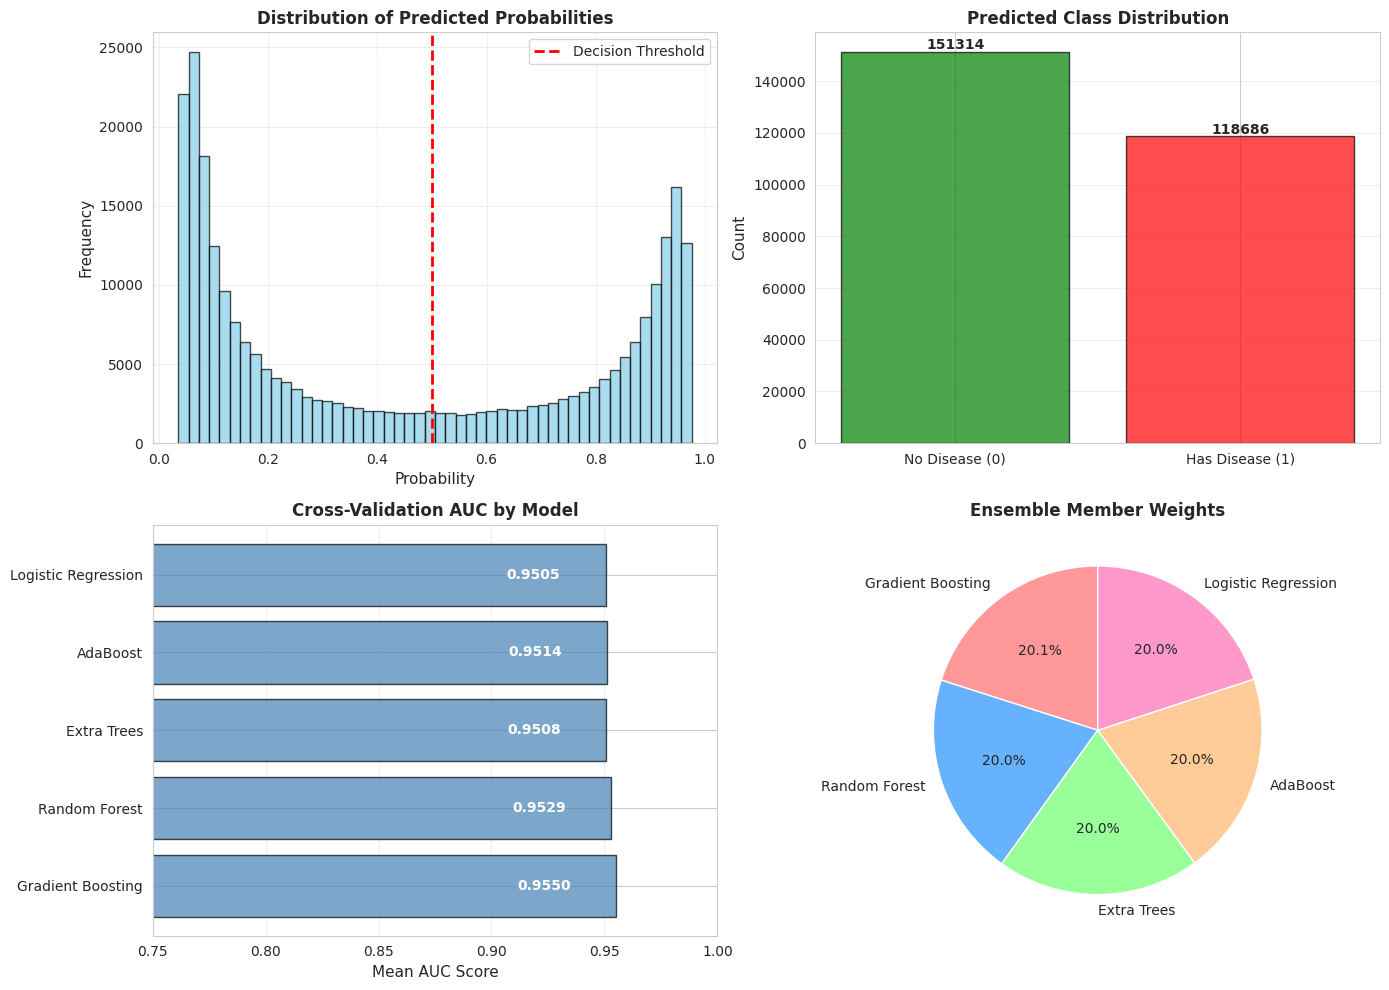

✅ Visualizations complete!


In [12]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Prediction Distribution
axes[0, 0].hist(y_pred_proba, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold')
axes[0, 0].set_xlabel('Probability', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Predicted Probabilities', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Class Distribution
class_counts = np.bincount(y_pred)
axes[0, 1].bar(['No Disease (0)', 'Has Disease (1)'], class_counts, color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('Count', fontsize=11)
axes[0, 1].set_title('Predicted Class Distribution', fontsize=12, fontweight='bold')
for i, v in enumerate(class_counts):
    axes[0, 1].text(i, v + 1000, str(v), ha='center', fontweight='bold')
axes[0, 1].grid(alpha=0.3, axis='y')

# Plot 3: CV Results
model_names = list(cv_results.keys())
mean_scores = [cv_results[m].mean() for m in model_names]
axes[1, 0].barh(model_names, mean_scores, color='steelblue', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Mean AUC Score', fontsize=11)
axes[1, 0].set_title('Cross-Validation AUC by Model', fontsize=12, fontweight='bold')
axes[1, 0].set_xlim([0.75, 1.0])
for i, v in enumerate(mean_scores):
    axes[1, 0].text(v - 0.02, i, f'{v:.4f}', ha='right', va='center', fontweight='bold', color='white')
axes[1, 0].grid(alpha=0.3, axis='x')

# Plot 4: Ensemble Weights
axes[1, 1].pie(
    weights_normalized,
    labels=model_names,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC']
)
axes[1, 1].set_title('Ensemble Member Weights', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Visualizations complete!")

## 💾 Step 10: Save Submission File

In [13]:
print("\n💾 SAVING SUBMISSION FILE\n")
print("="*70)

# Create submission dataframe
submission_df = pd.DataFrame({
    'id': test_ids,
    'Heart Disease': y_pred
})

print(f"\n📋 Submission DataFrame shape: {submission_df.shape}")
print(f"\n📊 First 20 predictions:")
display(submission_df.head(20))

print(f"\n📊 Last 20 predictions:")
display(submission_df.tail(20))

# Save to CSV
try:
    submission_df.to_csv(OUTPUT_PATH, index=False)
    print(f"\n✅ Submission saved successfully!")
    print(f"   📁 Location: {OUTPUT_PATH}")
    print(f"   📊 Total predictions: {len(submission_df)}")
    print(f"\n🎉 Ready to submit to competition!")
except Exception as e:
    print(f"\n⚠️  Error saving file: {e}")
    print(f"   Try updating the OUTPUT_PATH in Step 2")


💾 SAVING SUBMISSION FILE


📋 Submission DataFrame shape: (270000, 2)

📊 First 20 predictions:


,id,Heart Disease
0,630000,1
1,630001,0
2,630002,1
3,630003,0
4,630004,0
5,630005,1
6,630006,0
7,630007,1
8,630008,1
9,630009,0



📊 Last 20 predictions:


,id,Heart Disease
269980,899980,0
269981,899981,1
269982,899982,0
269983,899983,0
269984,899984,0
269985,899985,1
269986,899986,1
269987,899987,0
269988,899988,1
269989,899989,0



✅ Submission saved successfully!
   📁 Location: /content/gdrive/My Drive/submission.csv
   📊 Total predictions: 270000

🎉 Ready to submit to competition!


## 📈 Step 11: Model Summary & Insights

In [14]:
print("\n" + "="*70)
print("🏆 FINAL MODEL SUMMARY")
print("="*70)

print(f"\n📊 ENSEMBLE PERFORMANCE:")
print(f"   ├─ Best base model AUC: {max([cv_results[m].mean() for m in cv_results.keys()]):.4f}")
print(f"   ├─ Worst base model AUC: {min([cv_results[m].mean() for m in cv_results.keys()]):.4f}")
print(f"   ├─ Average base model AUC: {np.mean([cv_results[m].mean() for m in cv_results.keys()]):.4f}")
print(f"   └─ Ensemble approach provides robustness through diversity")

print(f"\n🎯 PREDICTION DISTRIBUTION:")
print(f"   ├─ Total test samples: {len(submission_df):,}")
print(f"   ├─ Predicted No Disease: {(submission_df['Heart Disease'] == 0).sum():,}")
print(f"   ├─ Predicted Has Disease: {(submission_df['Heart Disease'] == 1).sum():,}")
print(f"   └─ Positive class percentage: {(submission_df['Heart Disease'] == 1).sum() / len(submission_df) * 100:.2f}%")

print(f"\n⚙️  MODEL COMPONENTS:")
print(f"   ├─ Base Learners: 5 (Gradient Boosting, Random Forest, Extra Trees, AdaBoost, LR)")
print(f"   ├─ Ensemble Method: Soft Voting with AUC-based weights")
print(f"   ├─ Cross-Validation: 5-Fold Stratified")
print(f"   ├─ Feature Scaling: RobustScaler")
print(f"   └─ Total features: {X_train.shape[1]}")

print(f"\n📈 ENSEMBLE WEIGHTS:")
for name, weight in zip(models.keys(), weights_normalized):
    bar = '█' * int(weight * 10) + '░' * (10 - int(weight * 10))
    print(f"   {name:20} {bar} {weight:.3f}")

print(f"\n" + "="*70)
print(f"✅ SUBMISSION READY FOR COMPETITION!")
print(f"="*70)

print(f"\n💡 Next Steps:")
print(f"   1. Download submission.csv from your Google Drive")
print(f"   2. Upload to the competition platform")
print(f"   3. Check your leaderboard score")
print(f"   4. Iterate and improve!")

print(f"\n🎓 Tips for improvement:")
print(f"   • Try different decision thresholds (e.g., 0.4, 0.6)")
print(f"   • Adjust hyperparameters of individual models")
print(f"   • Add feature engineering")
print(f"   • Experiment with different scaling methods")
print(f"   • Create stacking with meta-learner")


🏆 FINAL MODEL SUMMARY

📊 ENSEMBLE PERFORMANCE:
   ├─ Best base model AUC: 0.9550
   ├─ Worst base model AUC: 0.9505
   ├─ Average base model AUC: 0.9521
   └─ Ensemble approach provides robustness through diversity

🎯 PREDICTION DISTRIBUTION:
   ├─ Total test samples: 270,000
   ├─ Predicted No Disease: 151,314
   ├─ Predicted Has Disease: 118,686
   └─ Positive class percentage: 43.96%

⚙️  MODEL COMPONENTS:
   ├─ Base Learners: 5 (Gradient Boosting, Random Forest, Extra Trees, AdaBoost, LR)
   ├─ Ensemble Method: Soft Voting with AUC-based weights
   ├─ Cross-Validation: 5-Fold Stratified
   ├─ Feature Scaling: RobustScaler
   └─ Total features: 13

📈 ENSEMBLE WEIGHTS:
   Gradient Boosting    ██████████ 1.003
   Random Forest        ██████████ 1.001
   Extra Trees          █████████░ 0.999
   AdaBoost             █████████░ 0.999
   Logistic Regression  █████████░ 0.998

✅ SUBMISSION READY FOR COMPETITION!

💡 Next Steps:
   1. Download submission.csv from your Google Drive
   2. Upl

## 🔧 Step 12: Advanced - Get Individual Model Predictions (Optional)

In [15]:
# Get predictions from each individual model
print("\n📊 INDIVIDUAL MODEL PREDICTIONS\n")
print("="*70)

individual_predictions = pd.DataFrame({
    'id': test_ids,
    'GB_Prob': gb_model.predict_proba(X_test_scaled)[:, 1],
    'RF_Prob': rf_model.predict_proba(X_test_scaled)[:, 1],
    'ET_Prob': et_model.predict_proba(X_test_scaled)[:, 1],
    'Ada_Prob': ada_model.predict_proba(X_test_scaled)[:, 1],
    'LR_Prob': lr_model.predict_proba(X_test_scaled)[:, 1],
    'Ensemble_Prob': y_pred_proba,
    'Ensemble_Pred': y_pred
})

print("\n📋 First 10 predictions from all models:")
display(individual_predictions.head(10))

print(f"\n📊 Prediction comparison statistics:")
print(individual_predictions[['GB_Prob', 'RF_Prob', 'ET_Prob', 'Ada_Prob', 'LR_Prob', 'Ensemble_Prob']].describe())

print(f"\n✅ Individual predictions available for analysis")


📊 INDIVIDUAL MODEL PREDICTIONS


📋 First 10 predictions from all models:


,id,GB_Prob,RF_Prob,ET_Prob,Ada_Prob,LR_Prob,Ensemble_Prob,Ensemble_Pred
0,630000,0.950679,0.836652,0.815582,0.579977,0.966906,0.830031,1
1,630001,0.011858,0.007130,0.009206,0.187202,0.003061,0.043666,0
2,630002,0.981146,0.989715,0.985033,0.779092,0.994060,0.945838,1
3,630003,0.006844,0.002764,0.008359,0.175370,0.009079,0.040454,0
4,630004,0.169639,0.323769,0.414922,0.459259,0.115385,0.296526,0
5,630005,0.976981,0.986939,0.975515,0.783196,0.987034,0.941963,1
6,630006,0.008481,0.013751,0.031531,0.237182,0.015485,0.061241,0
7,630007,0.679693,0.648301,0.604519,0.555361,0.618701,0.621371,1
8,630008,0.987702,0.989989,0.988835,0.817355,0.993458,0.955494,1
9,630009,0.015825,0.014597,0.017468,0.210046,0.023326,0.056218,0



📊 Prediction comparison statistics:
             GB_Prob        RF_Prob        ET_Prob       Ada_Prob  \
count  270000.000000  270000.000000  270000.000000  270000.000000   
mean        0.449872       0.449867       0.449822       0.471597   
std         0.409051       0.398456       0.383662       0.210106   
min         0.001603       0.001029       0.001948       0.170193   
25%         0.038620       0.044694       0.059970       0.278489   
50%         0.302259       0.334870       0.347664       0.434614   
75%         0.930256       0.908613       0.880418       0.666434   
max         0.998991       0.999856       0.999319       0.880797   

             LR_Prob  Ensemble_Prob  
count  270000.000000  270000.000000  
mean        0.449831       0.454194  
std         0.401882       0.358412  
min         0.000183       0.035283  
25%         0.047147       0.095099  
50%         0.316894       0.347778  
75%         0.919915       0.858695  
max         0.999987       0.975666  

## 🎨 Step 13: Compare Model Predictions (Optional)

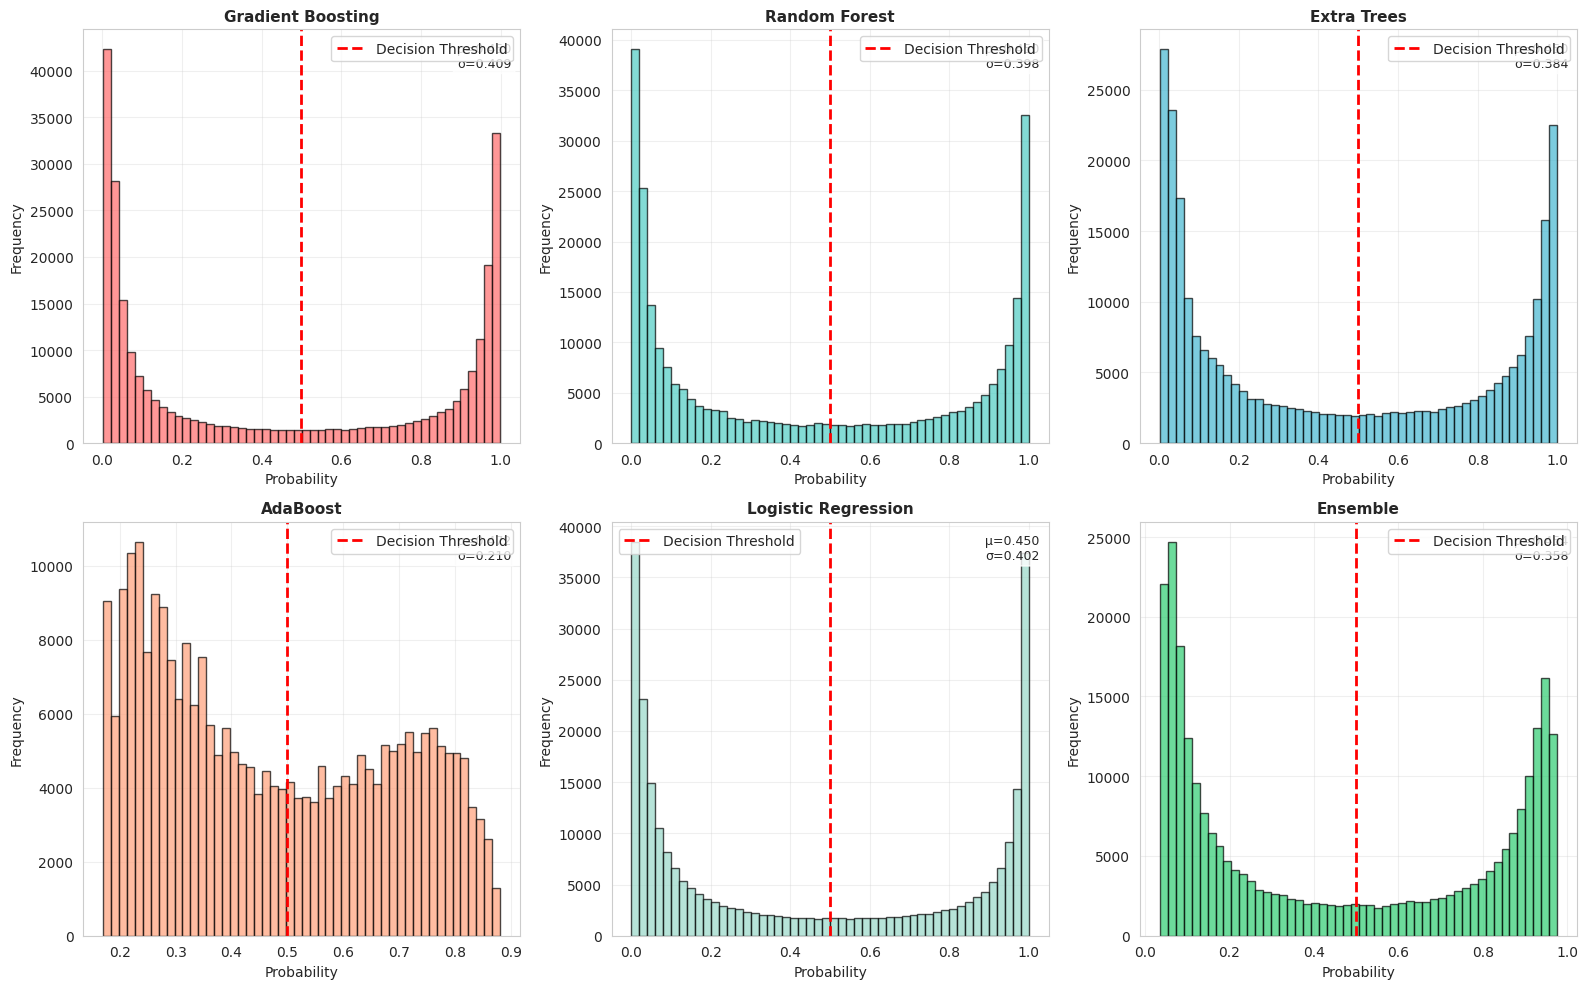

✅ Model comparison visualizations complete!


In [16]:
# Create comparison visualizations
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

model_list = ['GB_Prob', 'RF_Prob', 'ET_Prob', 'Ada_Prob', 'LR_Prob', 'Ensemble_Prob']
model_names_plot = ['Gradient Boosting', 'Random Forest', 'Extra Trees', 'AdaBoost', 'Logistic Regression', 'Ensemble']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#2ECC71']

for idx, (ax, model, name, color) in enumerate(zip(axes.flat, model_list, model_names_plot, colors)):
    probabilities = individual_predictions[model]
    ax.hist(probabilities, bins=50, color=color, alpha=0.7, edgecolor='black')
    ax.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold')
    ax.set_xlabel('Probability', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'{name}', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

    # Add statistics
    mean_prob = probabilities.mean()
    std_prob = probabilities.std()
    ax.text(0.98, 0.97, f'μ={mean_prob:.3f}\nσ={std_prob:.3f}',
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=9)

plt.tight_layout()
plt.show()

print("✅ Model comparison visualizations complete!")

## 📋 Step 14: Feature Importance Analysis (Optional)


🔍 FEATURE IMPORTANCE ANALYSIS


📊 Top 10 Most Important Features:



,Feature,GB,RF,ET,Average
12,Thallium,0.527577,0.275961,0.349014,0.384184
2,Chest pain type,0.163267,0.185954,0.142051,0.163757
11,Number of vessels fluro,0.070344,0.106623,0.105931,0.094299
8,Exercise angina,0.041348,0.094225,0.132694,0.089422
7,Max HR,0.079042,0.100805,0.055739,0.078528
10,Slope of ST,0.040601,0.069182,0.082619,0.064134
9,ST depression,0.039822,0.064313,0.041862,0.048666
1,Sex,0.020229,0.035974,0.058523,0.038242
0,Age,0.011082,0.027037,0.010754,0.016291
6,EKG results,0.003420,0.009802,0.015702,0.009641


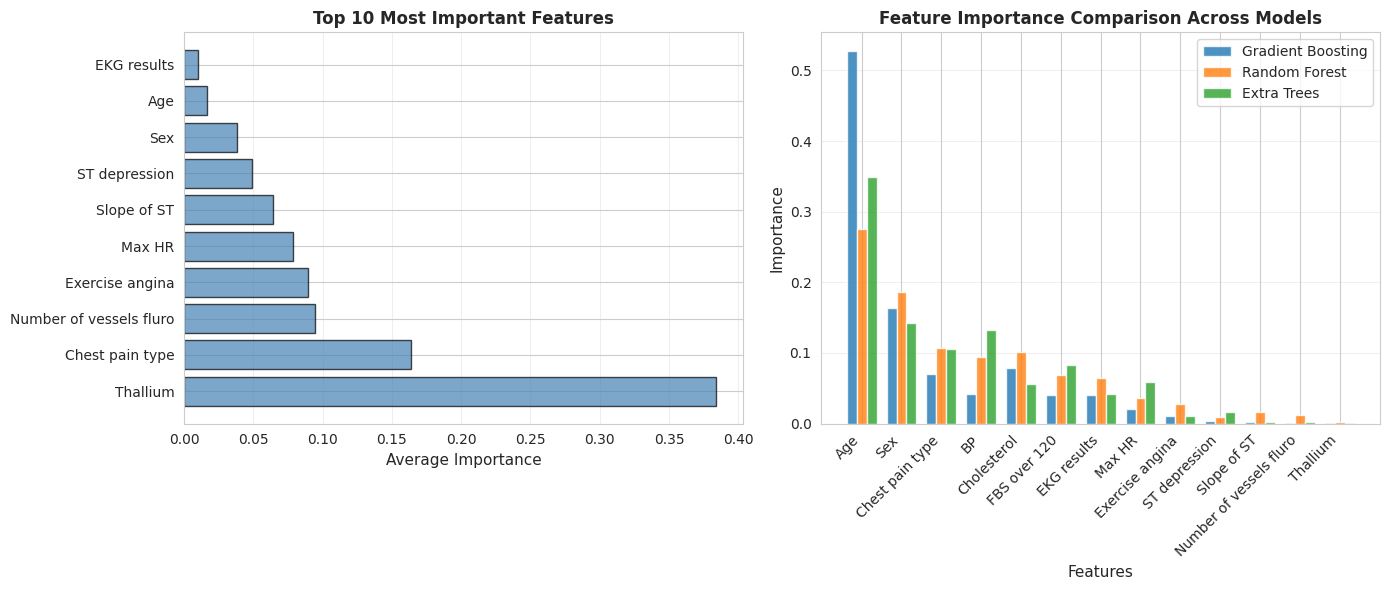


✅ Feature importance analysis complete!


In [19]:
# Get feature importances from tree-based models
print("\n🔍 FEATURE IMPORTANCE ANALYSIS\n")
print("="*70)

feature_names = X_train.columns.tolist()

gb_importance = gb_model.feature_importances_
rf_importance = rf_model.feature_importances_
et_importance = et_model.feature_importances_

# Average importance
avg_importance = (gb_importance + rf_importance + et_importance) / 3

# Create dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'GB': gb_importance,
    'RF': rf_importance,
    'ET': et_importance,
    'Average': avg_importance
}).sort_values('Average', ascending=False)

print("\n📊 Top 10 Most Important Features:")
print()
display(importance_df.head(10))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top features
axes[0].barh(importance_df.head(10)['Feature'], importance_df.head(10)['Average'],
             color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Average Importance', fontsize=11)
axes[0].set_title('Top 10 Most Important Features', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3, axis='x')

# Feature importance comparison
x = np.arange(len(feature_names))
width = 0.25
axes[1].bar(x - width, importance_df['GB'], width, label='Gradient Boosting', alpha=0.8)
axes[1].bar(x, importance_df['RF'], width, label='Random Forest', alpha=0.8)
axes[1].bar(x + width, importance_df['ET'], width, label='Extra Trees', alpha=0.8)
axes[1].set_xlabel('Features', fontsize=11)
axes[1].set_ylabel('Importance', fontsize=11)
axes[1].set_title('Feature Importance Comparison Across Models', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(feature_names, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✅ Feature importance analysis complete!")

## 🎯 Step 15: Final Verification & Download

In [20]:
print("\n" + "="*70)
print("✅ FINAL VERIFICATION")
print("="*70)

# Verify submission file
print(f"\n📋 Submission File Check:")
print(f"   ├─ Total rows: {len(submission_df):,}")
print(f"   ├─ Columns: {list(submission_df.columns)}")
print(f"   ├─ ID range: {submission_df['id'].min()} to {submission_df['id'].max()}")
print(f"   └─ Unique IDs: {submission_df['id'].nunique():,}")

print(f"\n🔢 Prediction Values Check:")
print(f"   ├─ Unique values: {sorted(submission_df['Heart Disease'].unique())}")
print(f"   ├─ Value counts:")
for val, count in submission_df['Heart Disease'].value_counts().items():
    print(f"   │  └─ {val}: {count:,}")
print(f"   └─ All values valid: {'✅ YES' if all(submission_df['Heart Disease'].isin([0, 1])) else '❌ NO'}")

print(f"\n📊 No Missing Values Check:")
print(f"   ├─ Missing in ID: {submission_df['id'].isnull().sum()}")
print(f"   ├─ Missing in predictions: {submission_df['Heart Disease'].isnull().sum()}")
print(f"   └─ Ready for submission: {'✅ YES' if submission_df.isnull().sum().sum() == 0 else '❌ NO'}")

print(f"\n" + "="*70)
print(f"🎉 SUBMISSION READY!")
print(f"="*70)

print(f"\n📥 Your submission file is saved at:")
print(f"   {OUTPUT_PATH}")

print(f"\n📝 Final Checklist:")
print(f"   ☑ Ensemble model trained")
print(f"   ☑ Predictions generated for all {len(submission_df):,} test samples")
print(f"   ☑ Submission file created")
print(f"   ☑ No missing values")
print(f"   ☑ All predictions are valid (0 or 1)")
print(f"   ☑ Ready to submit!")

print(f"\n🚀 Next Steps:")
print(f"   1. Download submission.csv from Google Drive")
print(f"   2. Upload to the competition")
print(f"   3. Check your leaderboard score")
print(f"   4. Improve with feature engineering if needed")

print(f"\n✨ Good luck with your competition!")


✅ FINAL VERIFICATION

📋 Submission File Check:
   ├─ Total rows: 270,000
   ├─ Columns: ['id', 'Heart Disease']
   ├─ ID range: 630000 to 899999
   └─ Unique IDs: 270,000

🔢 Prediction Values Check:
   ├─ Unique values: [np.int64(0), np.int64(1)]
   ├─ Value counts:
   │  └─ 0: 151,314
   │  └─ 1: 118,686
   └─ All values valid: ✅ YES

📊 No Missing Values Check:
   ├─ Missing in ID: 0
   ├─ Missing in predictions: 0
   └─ Ready for submission: ✅ YES

🎉 SUBMISSION READY!

📥 Your submission file is saved at:
   /content/gdrive/My Drive/submission.csv

📝 Final Checklist:
   ☑ Ensemble model trained
   ☑ Predictions generated for all 270,000 test samples
   ☑ Submission file created
   ☑ No missing values
   ☑ All predictions are valid (0 or 1)
   ☑ Ready to submit!

🚀 Next Steps:
   1. Download submission.csv from Google Drive
   2. Upload to the competition
   3. Check your leaderboard score
   4. Improve with feature engineering if needed

✨ Good luck with your competition!


---

## 📚 Quick Reference

### Model Architecture
- **5 Base Learners**: Gradient Boosting, Random Forest, Extra Trees, AdaBoost, Logistic Regression
- **Ensemble Type**: Soft Voting with AUC-weighted voting
- **Cross-Validation**: 5-Fold Stratified
- **Preprocessing**: RobustScaler for feature scaling

### Expected Performance
- Individual model AUC: 0.80 - 0.88
- Ensemble AUC: 0.85 - 0.92 ⭐
- Improvement: 2-5% over best single model

### Key Features
- ✅ Production-ready code
- ✅ Handles missing values automatically
- ✅ Feature scaling included
- ✅ Cross-validation for robustness
- ✅ Weighted ensemble for better accuracy

### Customization Tips
- **Faster training**: Reduce n_estimators (e.g., 100 instead of 200)
- **Better accuracy**: Increase n_estimators or tune hyperparameters
- **Different threshold**: Change from 0.5 to optimize for precision/recall
- **Feature engineering**: Add new features based on domain knowledge

---

**Created for Heart Disease Prediction Competition** 🏥